# Analysis of dumps
## Raw Data
The test suite stores tcpdump output in a json format. Because this contains information about each packet, it can be parsed to determine information that would not normally be revealed by the transfer program itself. For example, how much overhead or compression there was.

In [1]:
from helpers import get_dump_fnames, get_dumps, organize_dumps

PROTOCOLS = ["scp", "hpn-scp", "ftp", "gridftp"]
N = None # The number of records to retrieve (None=all)

# Find the relevant dumps
names = get_dump_fnames(PROTOCOLS, N)
dumps = get_dumps(names)

# Fetch relevant columns and rename them
df, ids = organize_dumps(dumps)

In [2]:
df

,Protocol,Batch ID,Stored Packets,Start Time,File Size (bytes),Bytes Down,Bytes Up,Bytes Total,Ratio (%),Time (s),Speed (bytes/s)
0,ftp,58,False,2015-10-15 14:07:40,536870912,537872041,1281883,539153924,100.43,21.92,24537958.07
1,ftp,275,False,2015-10-15 14:25:43,536870912,537945577,1288499,539234076,100.44,18.78,28644599.41
2,ftp,233,False,2015-10-15 14:43:50,536870912,537960153,1296611,539256764,100.44,21.76,24722433.50
3,ftp,121,False,2015-10-15 15:01:49,536870912,529905737,1264963,531170700,98.94,23.95,22125500.50
4,ftp,228,False,2015-10-15 15:20:06,536870912,538010953,1273667,539284620,100.45,24.31,22131260.92
5,ftp,72,False,2015-10-16 01:00:20,536870912,537795545,1315803,539111348,100.42,24.38,22058882.08
6,ftp,185,False,2015-10-16 01:18:38,536870912,538108265,1312227,539420492,100.47,23.23,23164367.84
7,ftp,76,False,2015-10-16 01:36:51,536870912,538005257,1284003,539289260,100.45,23.68,22719816.60
8,ftp,42,False,2015-10-16 01:54:58,536870912,538055385,1284067,539339452,100.46,22.53,23881730.36
9,ftp,291,False,2015-10-16 02:13:13,536870912,537805425,1289699,539095124,100.41,22.28,24138484.07


## Remove outliers
The data doesn't tend to have outliers for large filesizes, but with file less than 10Mb there can be some anomalies

In [3]:
sel = df[df["File Size (bytes)"] < 10000000] # Choose everything less than 10Mb
# If the ratio of filesize to packets is more than 1 million, there is a problem
outliers = sel[sel["Bytes Total"]/sel["File Size (bytes)"] > 1000000]

# Remove only those lines. For now, leave the rest of the batch
df.drop(outliers.index, inplace=True)

print "Removed %s entries" % len(outliers)

Removed 0 entries


## Aggregate Data
The table above can be aggregated per filesize and protocol, then displayed visually.

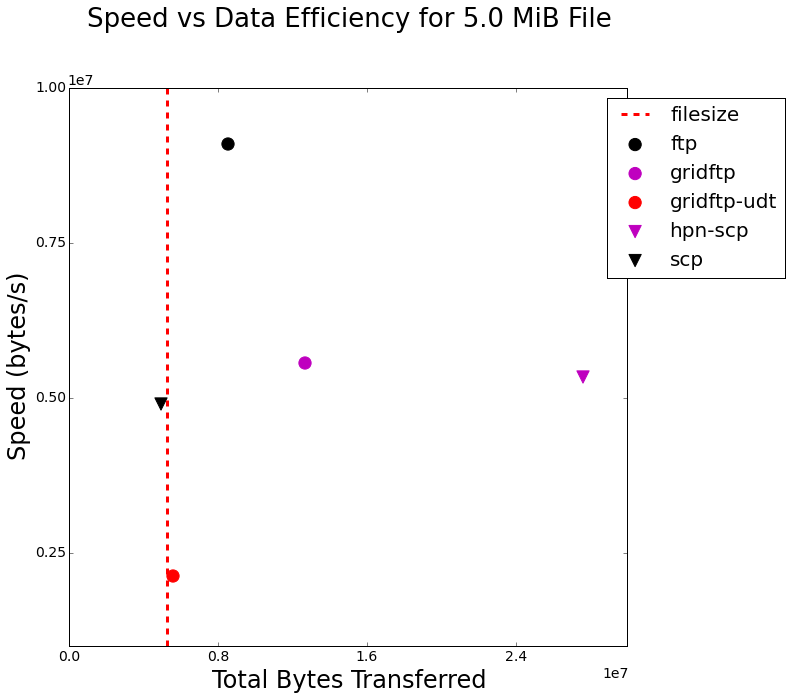

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt, rcParams
from ipywidgets import interact, fixed
import numpy as np
import pandas as pd

from plot import plot_speed_efficiency
from helpers import sizeof_fmt

LABEL_SIZE = 14

rcParams['figure.figsize'] = (10, 10)
rcParams['xtick.labelsize'] = LABEL_SIZE
rcParams['ytick.labelsize'] = LABEL_SIZE

# Group by Filesize and then Protocol
agg = df.groupby(["File Size (bytes)", "Protocol"]).aggregate(np.mean)
agg.drop(["Batch ID", "Stored Packets"], axis=1, inplace=True)

sizes = {str(sizeof_fmt(x)):x for x in set(df["File Size (bytes)"])}
agg_interact = interact(plot_speed_efficiency, df=fixed(agg), filesize=sizes)

In [5]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)

# print agg.reset_index().to_latex()
agg

Bytes Down   Bytes Up  Bytes Total  Ratio (%)  \
File Size (bytes) Protocol                                                      
5242880           ftp            8413007.7   110014.3    8523022.0      162.6   
                  gridftp        7412012.0  5270788.4   12682800.4      241.9   
                  gridftp-udt    5543205.4     6239.1    5549444.5      105.8   
                  hpn-scp        5095229.0 22532226.6   27627455.6      527.0   
                  scp            4808391.8   104417.7    4912809.5       93.7   
536870912         ftp          534084205.9  1298533.8  535382739.7       99.7   
                  gridftp      535240945.3     4425.0  535245370.3       99.7   
                  gridftp-udt  553768959.7   173186.2  553942145.9      103.2   
                  hpn-scp      535401726.9   164294.4  535566021.3       99.8   
                  scp          535381827.3   185875.7  535567702.9       99.8   
1073741824        ftp         1072881895.1  2558993.1 1075440888.1      100.2   
                  gridftp     1071918333.8     4422.0 1071922755.8       99.8   
                  gridftp-udt 1112012162.9   340049.3 1112352212.1      103.6   
                  hpn-scp     1070826111.6   341411.1 1071167522.6       99.8   
                  scp         1070596084.3   382239.0 1070978323.3       99.7   
1610612736        ftp         1609012156.9  3810770.9 1612822927.7      100.1   
                  gridftp     1608155406.3     4423.1 1608159829.5       99.8   
                  gridftp-udt 1668742869.2   507308.4 1669250177.6      103.6   
                  hpn-scp     1608701999.0   513687.6 1609215686.6       99.9   
                  scp         1608169009.5   581313.7 1608750323.2       99.9   
2147479552        ftp         2144495341.4  5166344.3 2149661685.7      100.1   
                  gridftp     2145845215.4     4422.5 2145849637.9       99.9   
                  gridftp-udt 2228159986.6   676775.8 2228836762.4      103.8   
                  hpn-scp     2145264352.9   687628.8 2145951981.7       99.9   
                  scp         2148226021.1   753291.0 2148979312.1      100.1   
2540610608        ftp         2541336324.7  6128837.9 2547465162.6      100.3   
                  gridftp     2538172141.5     4412.9 2538176554.4       99.9   
                  gridftp-udt 2636682223.1   799058.2 2637481281.3      103.8   
                  hpn-scp     2533961524.4   806759.9 2534768284.3       99.8   
                  scp         2535048746.9   908753.4 2535957500.3       99.8   

                               Time (s)  Speed (bytes/s)  
File Size (bytes) Protocol                                
5242880           ftp               1.4        9092596.7  
                  gridftp           1.3        5560789.2  
                  gridftp-udt       2.7        2121498.5  
                  hpn-scp           1.0        5339580.5  
                  scp               1.0        4907455.3  
536870912         ftp              24.4       22069687.9  
                  gridftp          25.3       21358608.5  
                  gridftp-udt      30.2       18732210.9  
                  hpn-scp          24.7       21895264.8  
                  scp              24.4       22088599.5  
1073741824        ftp              47.1       22940550.1  
                  gridftp          47.6       22580395.8  
                  gridftp-udt      50.4       22086429.9  
                  hpn-scp          46.3       23154917.1  
                  scp              46.1       23375141.7  
1610612736        ftp              68.3       23594127.5  
                  gridftp          70.5       22868925.7  
                  gridftp-udt      74.0       22557996.6  
                  hpn-scp          68.7       23465480.1  
                  scp              68.4       23536710.8  
2147479552        ftp             100.0       21704026.4  
                  gridftp          95.0       22610027.5  
                  gridf

## Metrics per filesize
The above data can also be shown as two separate graphs, as a function of filesize.

## Speed

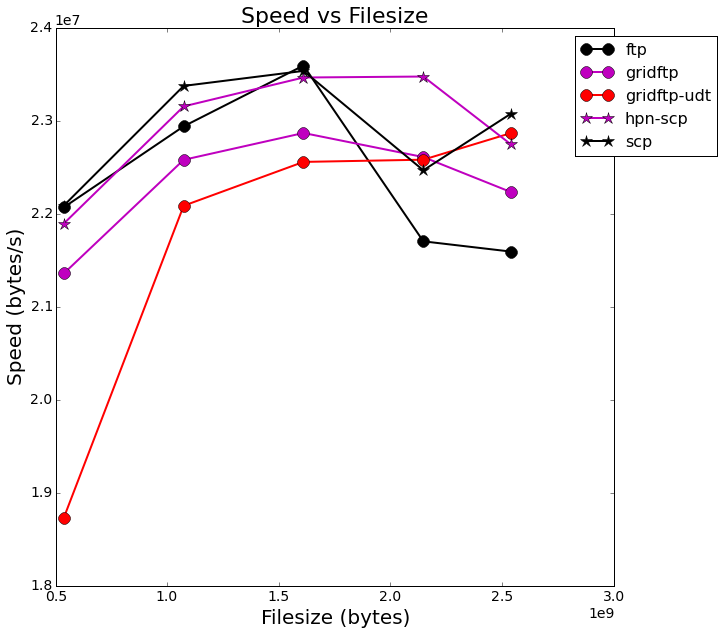

In [6]:
%matplotlib inline
from plot import plot_speed_per_filesize

rcParams['figure.figsize'] = (10, 10)

plot_speed_per_filesize(df, ratio=False, ignore_small=True)

## Data Usage

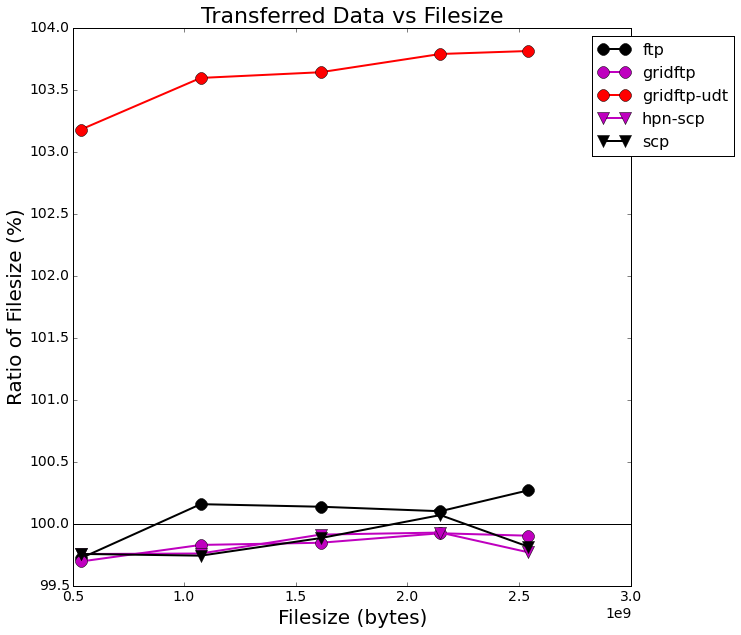

In [7]:
%matplotlib inline
from plot import plot_data_per_filesize

rcParams['figure.figsize'] = (10, 10)

plot_data_per_filesize(df, ignore_small=True)

# Network stability
The network may be busier at certain times. If the tests are run at different hours of the day, this can be explored.

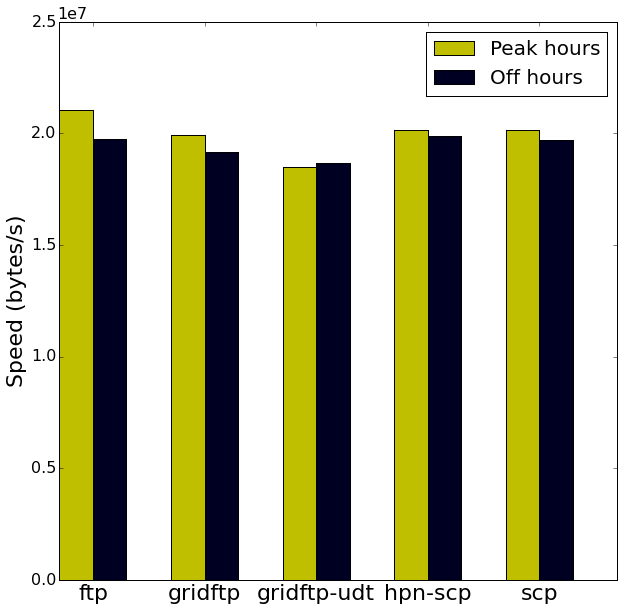

In [8]:
%matplotlib inline
from datetime import time

from plot import plot_speed_day_night

LABEL_SIZE = 16
rcParams['figure.figsize'] = (10, 10)
rcParams['xtick.labelsize'] = LABEL_SIZE
rcParams['ytick.labelsize'] = LABEL_SIZE

# Group the data into working hours and off hours
t1 = time(11, 0 ,0)
t2 = time(15, 0, 0)
is_day = lambda x: t1 <= x.time() <= t2
day = df[[is_day(x) for x in df["Start Time"]]]
night = df[[not is_day(x) for x in df["Start Time"]]]

# Aggregate the frames by protocol, fetch their speed
get_speed = lambda df: df.groupby(["Protocol"]).aggregate(np.mean)["Speed (bytes/s)"] 
speed_day = get_speed(day)
speed_night = get_speed(night)
    
plot_speed_day_night(speed_day, speed_night, title=False)


In [9]:
from scipy import stats
import pandas as pd

print "The null hypothesis is that the samples have identical average (expected) values."
print "A value of None means that the data was not normal"
diff = pd.DataFrame(columns=set(day["Protocol"]))

for p in set(day["Protocol"]):
    a = day[day["Protocol"] == p]["Speed (bytes/s)"]
    b = night[night["Protocol"] == p]["Speed (bytes/s)"]
    if stats.normaltest(a)[1] > 0.05 or stats.normaltest(b)[1] > 0.05:
        diff[p] = [None]
    else:
        diff[p] = [stats.ttest_ind(a, b)[1]]

diff = diff.transpose()
diff.columns = ["p-value"]
# print diff.to_latex()
diff

The null hypothesis is that the samples have identical average (expected) values.
A value of None means that the data was not normal


,p-value
ftp,0.4
scp,0.5
hpn-scp,0.7
gridftp,0.4
gridftp-udt,0.9


# Time taken
This is a practical point of view, and the graph that a non-technical user would care about.

The time to transfer the largest file size is plotted.

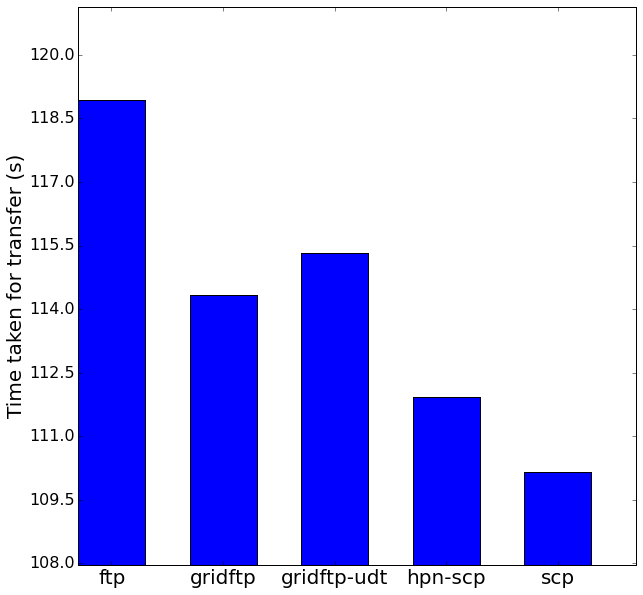

In [10]:
from plot import plot_time

LABEL_SIZE = 16
rcParams['figure.figsize'] = (10, 10)
rcParams['xtick.labelsize'] = LABEL_SIZE
rcParams['ytick.labelsize'] = LABEL_SIZE

largest = max(agg.index.levels[0])
sel = agg.loc[largest]
    
plot_time(sel, title=False)
# sel

## Topography of Transfer
Displaying the packet sizes against a time axis gives more insight into each protocol. It's also a good representation of network conditions, as breaks or delays are easily seen.

In [11]:
%matplotlib inline
import warnings

from plot import plot_packets

warnings.simplefilter('ignore', UserWarning)
rcParams['figure.figsize'] = (12, 12)

def reverse_lookup(bid):
    for key, val in ids.items():
        if val == bid:
            return key
    return None

batch_ids = {str(x):reverse_lookup(x) for x in set(df[df["Stored Packets"]]["Batch ID"])}

if batch_ids:
    packet_interact = interact(plot_packets, batch_id=batch_ids)
else:
    print "No batches with stored packets found"
    print "Run test.py with the --store-packets argument"

At least one protocol was missing from batch 7707605165168701577
